# Figure 9

Notebook to create plots for figure 9

- A) Anthropogenic air-sea CO2exchange (FANT) for 1985-2018 from LDEO-HPDand four other products:  SOMFFN, MLS, CMEMS, CSIR-ML6.  Positive is to the atmosphere.Gray dash is the mean of the 9 GOBM priors, which are also the basis for the ocean sink esti-mate of the Global Carbon Budget 2020 (Friedlingstein et al., 2020).  
- B) Anthropogenic CO2flux for 1990-99, 1994-2007, and 2009-2018.  Light gray bar indicates IPCC AR4 or interiorobservation-based estimates with uncertainty.  Dark gray bar is the mean of the nine GOBMs.Colored bars indicate observation-based estimates.  The white line separatesFNETfrom theproducts andFRIV, estimated as the average of three estimates (0.49 PgC/yr), see section 2.8

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}

# standard imports
import os
import scipy
import numpy as np
import xarray as xr
import pandas as pd
import glob

# modeling
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pgml

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# plotting
import cmocean as cm
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from matplotlib.ticker import AutoMinorLocator
from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot

# regression metrics
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
#from sklearn.metrics import explained_variance_score

import pgml
import os
# settings 
pd.set_option("display.max_columns", 100)

In [2]:
#dir_raw = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/raw'
#dir_clean = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/clean'
dir_figs = '/home/gloege/projects/ldeo_hpd/reports/figures'

## Function Definitions

In [3]:
### ================================================
### force time vector to be proper format and range
### ================================================
def make_dates(start=None, end=None):
    '''
    Creates a monthly DateTime64 vector centered on 15th each month
    
    Input
    =========
    start : str 'YYYY-MM'
    end :   str 'YYYY-MM'
            
    Output
    =========
    dates : dataArray 
    
    Example
    ==========
    dates = make_dates(start='1990-01', end='2017-12')
    '''
    dates = pd.date_range(start=f'{start}-01T00:00:00.000000000', 
                          end=f'{end}-01T00:00:00.000000000',
                          freq='MS')+ np.timedelta64(14, 'D')
    da = xr.DataArray(dates, dims='time')
    
    return da

In [4]:
def convert_to_datetime64(times, use_cftime):
    """
    Return times as np.datetime64[ns] or cftime.DatetimeProlepticGregorian
    depending on whether the dates fall within the inclusive bounds of 
    np.datetime64[ns]: [1678-01-01 AD, 2261-12-31 AD].

    Alternatively, always returns as cftime.DatetimeProlepticGregorian if
    `use_cf_time` is True.
    
    source : https://gitlab.com/deltares/imod/imod-python/commit/9b1ae0e9a51b0fefe6ef86c2a2f9ef988024b464
    """
    out_of_bounds = False
    if use_cftime:
        converted = [
            cftime.DatetimeProlepticGregorian(*time.timetuple()[:6]) for time in times
        ]
    else:
        for time in times:
            year = time.year
            if year < 1678 or year > 2261:
                out_of_bounds = True
                break

        if out_of_bounds:
            warnings.warn(
                "Dates are outside of np.datetime64[ns] timespan."
                "Converting to cftime.DatetimeProlepticGregorian."
            )
            converted = [
                cftime.DatetimeProlepticGregorian(*time.timetuple()[:6]) for time in times
            ]
        else:
            converted = [np.datetime64(time, "ns") for time in times]

    return converted

In [5]:
def area(lat, dlat=1, dlon=1):
    '''
    WGS 84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    look table 3.7
    
    using the WGS 84 ellipsoid 
    
    R equation is here: https://planetcalc.com/7721/
    '''
    deg_to_rad = np.pi/180
    dlat_r = dlat * deg_to_rad
    dlon_r = dlon * deg_to_rad
    lat_r = lat * deg_to_rad
    
    # radius by latitude assuming oblate spheroid
    # using a and b from WGS 84
    # I rounded b from 6356752.3142
    a = 6378137 # semimajor (m)
    b = 6356752 # semiminor (m)
    numer = ( (a**2 * np.cos(lat_r))**2 + (b**2 * np.sin(lat_r))**2 )
    denom = ( (a * np.cos(lat_r))**2 + (b * np.sin(lat_r))**2 )
    R = np.sqrt(numer / denom) # radius of earth 
    
    return R * R * dlat_r * dlon_r  * np.cos(lat_r)

## broadcast area to lon and time
#lon = np.arange(0.5,360,1)
#time = pd.date_range(start='1982-01-01T00:00:00.000000000', 
#                     end='2016-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
#ds_bc = xr.DataArray(np.zeros([len(time),len(lon)]), coords=[('time', time),('lon', lon)])
#ds_data, ds_mask = xr.broadcast(area(ds_hpd['lat']), ds_bc)
#ds_data = ds_data.transpose('time','lat','lon')
#ds_area = ds_data.rename('area').to_dataset()

## Load HPD

In [6]:
%%time
ds_hpd = xr.open_dataset('/local/data/artemis/workspace/gloege/ldeo-hpd/LDEO-HPD_fgco2_v20210426_1x1_198201-201812.nc')

CPU times: user 19.1 ms, sys: 5.74 ms, total: 24.8 ms
Wall time: 148 ms


# Load products

In [7]:
ds_prod = xr.open_dataset('/local/data/artemis/workspace/gloege/gregor/IPCC-AR6_FCO2_DataProducts_filled_20201118.nc')

ds_prod['lon'] = [lon if lon>0 else lon+360 for lon in ds_prod['lon'].values]
ds_prod['time'] = pd.date_range(
    start=f'1985-01-01T00:00:00.000000000', 
    end=f'2018-12-01T00:00:00.000000000',
    freq='MS') + np.timedelta64(14, 'D')

ds_prod['fgco2'] = ds_prod['fgco2']*365
ds_prod['fgco2'].attrs = {'description':'Air-sea CO2 fluxes, where negative is into the ocean',
                         'units':'mol/m2/yr'}

# Flux density

## models

In [8]:
flux_den_mod = pd.read_csv('/local/data/artemis/workspace/gloege/GCB/GCB2020_fluxes.csv')

In [9]:
flux_den_mod['Mean models'] = flux_den_mod['Mean models']*(-1)

In [10]:
flux_den_mod.head()

,years,CESM-ETH,CSIRO,FESOM,MPI,CNRM,PlankTOM,NorESM,Princeton,IPSL,Mean models,model std
0,1959,0.95,1.03,1.01,0.80,0.79,0.89,1.10,0.35,0.83,-0.86,0.22
1,1960,0.89,1.03,1.03,0.73,0.77,0.84,1.07,0.48,0.71,-0.84,0.19
2,1961,0.62,0.89,0.90,0.72,0.50,0.80,1.01,0.42,0.59,-0.72,0.20
3,1962,0.72,1.00,0.84,0.65,0.44,0.94,1.19,0.51,0.62,-0.77,0.24
4,1963,0.90,1.18,0.93,0.72,0.63,1.06,1.35,0.66,0.81,-0.92,0.24


## prodcuts

In [11]:
flux_den_prods = (ds_prod['fgco2'].mean('wind')*(12.01/10**15)*ds_prod['area']).sum(['lat','lon'])
flux_den_prods_yr = flux_den_prods.groupby('time.year').mean('time')

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## LDEO HPD 
HPD = 2.6 ±  0.2

GBC = 2.5 ± 0.6

In [12]:
%%time
flux_den_hpd_yr = ds_hpd['fgco2_glob'].groupby('time.year').mean('time')

CPU times: user 17.8 ms, sys: 898 µs, total: 18.7 ms
Wall time: 42 ms


In [13]:
flux_den_hpd_yr.sel(year=slice(2010,2018)).mean('year').std()

<xarray.DataArray 'fgco2_glob' ()>
array(0.08109112)

In [13]:
# 2009-2018 avg
print(f"{(flux_den_hpd_yr-0.42).mean('model').sel(year=slice(2009,2018)).mean().values}")
print(f"{(flux_den_hpd_yr-0.42).mean('model').sel(year=slice(2009,2018)).std().values}")

-2.598544112326532
0.15611197421927223


In [76]:
out_hpd = np.array([flux_den_hpd_yr.mean('model').sel(year=slice(2009,2018)).mean().values])

In [ ]:
da_gbc = xr.DataArray(
    data=flux_den_mod['Mean models'],
    dims=["year"],
    coords=dict(
        year=flux_den_mod['years'],
    ))

In [102]:
out_gbc = np.array([da_gbc.sel(year=slice(2009,2018)).mean().values])

In [16]:
#for prod in list(flux_den_prods_yr.product.values):
#    print(prod)
 #   val = (flux_den_prods_yr-0.49).sel(product=prod).sel(year=slice(2009,2018)).mean().values
 #   print(val)
    
out_hpd = np.array([flux_den_hpd_yr.mean('model').sel(year=slice(2009,2018)).mean().values])

out = np.array([flux_den_prods_yr.\
       sel(product=prod).\
       sel(year=slice(2009,2018)).\
       mean().\
       values for prod in ['MPI-SOMFFN', 'JENA-MLS', 'CMEMS-FFNN2', 'CSIR-ML6']])


out_2009 = np.concatenate((out_hpd, out))

In [104]:
out_2009

array([-2.479     , -2.17854411, -2.32738395, -2.1827113 , -2.23096817,
       -2.35729158])

In [ ]:
positions= 3
colors = ['b', 'k', 'c', 'g', 'r']
for data in out_2009:

    means = [mn_1990_1999-0.49, mn_1994_2007-0.49]
    
    # add bar plot
    ax.bar(positions+mult*bar_width, means, color=colors[mult-2], 
           edgecolor=edgecolor, width=bar_width, yerr=[0.52,0.52], ecolor=[0.5,0.5,0.5]) #yerr=[[-0.4],[-0.1]],
    
    mult = mult+1


# Flux bar

In [14]:
da_gbc = xr.DataArray(
    data=flux_den_mod['Mean models'],
    dims=["year"],
    coords=dict(
        year=flux_den_mod['years'],
    ))

In [119]:
np.mean([0.46,
0.47,
0.50,
0.49,
0.45,
0.44,
0.42,
0.51,
0.51,
0.47])

0.472

In [120]:
np.mean([0.45,
0.44,
0.42,
0.51,
0.51,
0.47,
0.47,
0.48,
0.51,
0.52,
0.53,
0.52,
0.55,
0.51])

0.4921428571428571

In [121]:
np.mean([0.54,
0.53,
0.54,
0.60,
0.57,
0.58,
0.61,
0.55,
0.58,
0.61])

0.571

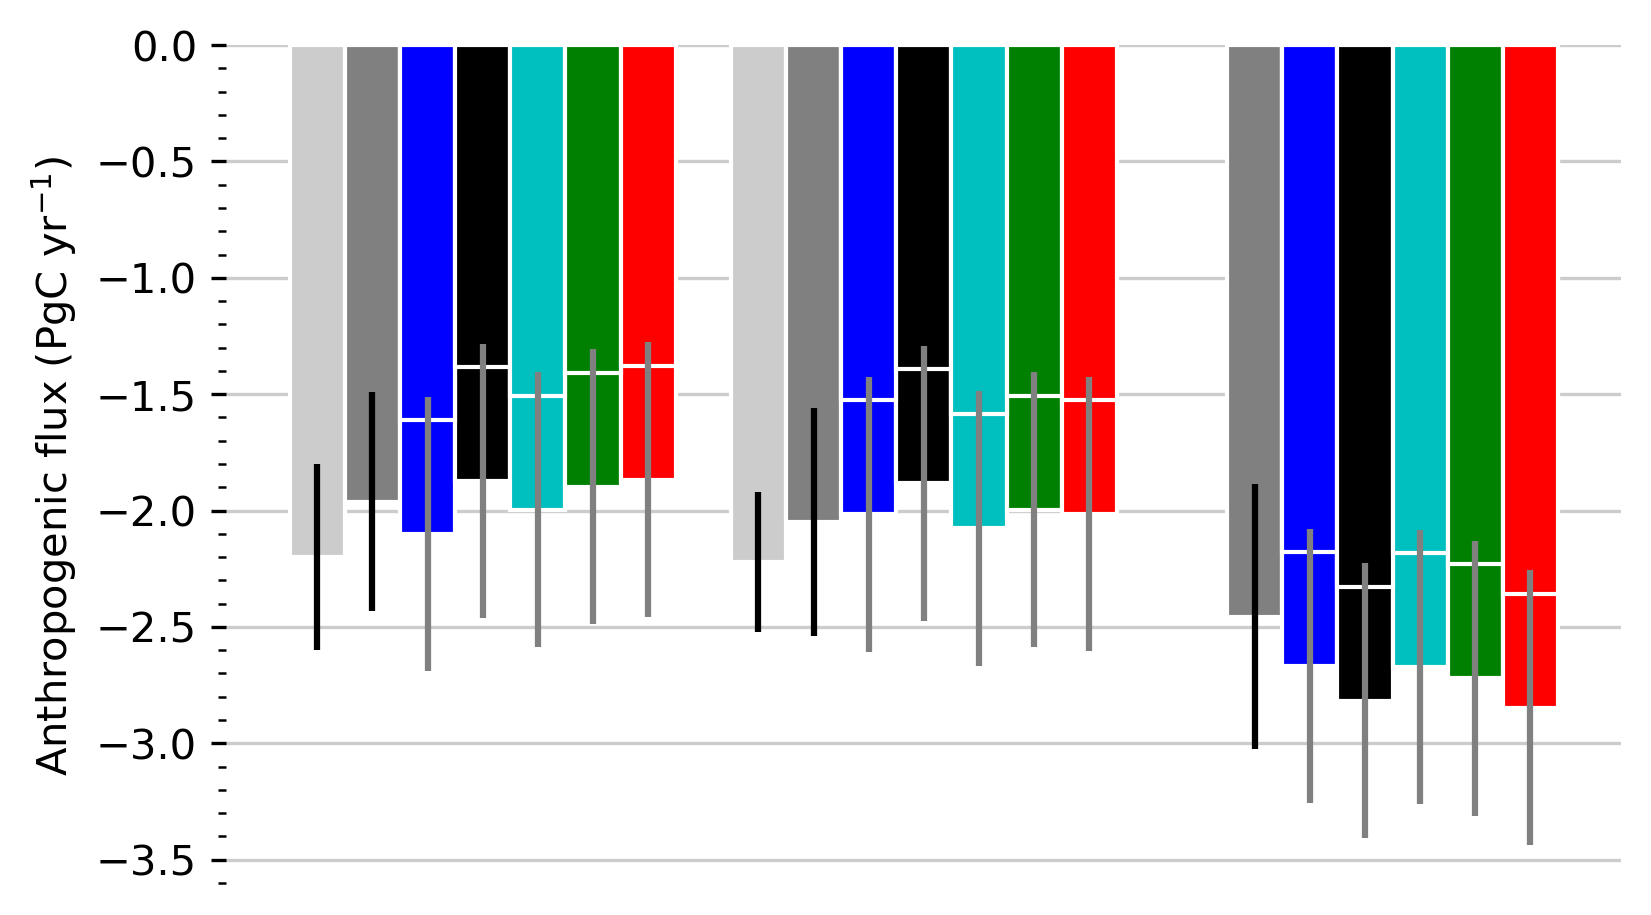

In [20]:
fig = plt.figure(figsize=(6,6/1.618)) 
ax = fig.add_subplot(111)

bar_width = 1/8
edgecolor = 'w'
# -------------------------------------
# Plot data
# table ts.1 https://www.ipcc.ch/site/assets/uploads/2018/05/ar4_wg1_full_report-1.pdf
# -------------------------------------
label = ['90_99', '00_09']
means = [-2.2, -2.6 + 0.38]
std = [0.4, 0.3]
positions = np.arange(0,len(means))
ax.bar(positions, means, color=[0.8,0.8,0.8], edgecolor=edgecolor, yerr=std, width=bar_width) #hatch='/')
#ax.bar(positions, means, color=[0.8,0.8,0.8], edgecolor=edgecolor, yerr=std, width=bar_width, hatch='/')
#ax.rcParams['hatch.color'] = 'k'

# -------------------------------------
# added river
# -------------------------------------
mult=1
means = [da_gbc.sel(year=slice(1990,1999)).mean(), 
         da_gbc.sel(year=slice(1994,2007)).mean()]
ax.bar(positions+mult*bar_width, means, color=[0.5,0.5,0.5], edgecolor=edgecolor, width=bar_width, yerr=[0.47,0.49])

mult = 2
colors = ['b', 'k', 'c', 'g', 'r']
for data in [flux_den_hpd_yr,  
             flux_den_prods_yr.sel(product='MPI-SOMFFN'), 
             flux_den_prods_yr.sel(product='JENA-MLS'),
             flux_den_prods_yr.sel(product='CMEMS-FFNN2'),
             flux_den_prods_yr.sel(product='CSIR-ML6')]:
    mn_1990_1999 = data.sel(year=slice(1990,1999)).mean()
    mn_1994_2007 = data.sel(year=slice(1994,2007)).mean()
    means = [mn_1990_1999-0.49, mn_1994_2007-0.49]
    
    # add bar plot
    ax.bar(positions+mult*bar_width, means, color=colors[mult-2], 
           edgecolor=edgecolor, width=bar_width, yerr=[0.59,0.59], ecolor=[0.5,0.5,0.5]) #yerr=[[-0.4],[-0.1]],
    
    mult = mult+1
    

# -------------------------------------
# Contempory flux 
# -------------------------------------
mult=2
#colors = ['b',  [0.5,0.5,0.5], 'k', 'c', 'g', 'r']
colors = ['b', 'k', 'c', 'g', 'r']
for data in [flux_den_hpd_yr,  
             flux_den_prods_yr.sel(product='MPI-SOMFFN'), 
             flux_den_prods_yr.sel(product='JENA-MLS'),
             flux_den_prods_yr.sel(product='CMEMS-FFNN2'),
            flux_den_prods_yr.sel(product='CSIR-ML6')]:
    mn_1990_1999 = data.sel(year=slice(1990,1999)).mean()
    mn_1994_2007 = data.sel(year=slice(1994,2007)).mean()
    means = [mn_1990_1999, mn_1994_2007]
    
    # add bar plot
    ax.bar(positions+mult*bar_width, means, color=colors[mult-2], 
           edgecolor=edgecolor, width=bar_width) #yerr=[[-0.4],[-0.1]],
    mult = mult+1






positions= 2
mult= 3
means = [da_gbc.sel(year=slice(2008,2018)).mean()]
ax.bar(positions+mult*bar_width-2*bar_width, da_gbc.sel(year=slice(2008,2018)).mean(), 
       color=[0.5,0.5,0.5], edgecolor=edgecolor, width=bar_width, yerr=0.57)

mult=4
colors = ['b', 'k', 'c', 'g', 'r']
for data in out_2009:
    # add bar plot
    ax.bar(positions+mult*bar_width-2*bar_width, data-0.49, color=colors[mult-4], 
           edgecolor=edgecolor, width=bar_width, yerr=[0.59], ecolor=[0.5,0.5,0.5]) #yerr=[[-0.4],[-0.1]],
    
    mult = mult+1
    
positions= 2
mult=4
colors = ['b', 'k', 'c', 'g', 'r']
for data in out_2009:
    # add bar plot
    ax.bar(positions+mult*bar_width-2*bar_width, data, color=colors[mult-4], 
           edgecolor=edgecolor, width=bar_width, ecolor=[0.5,0.5,0.5]) #yerr=[[-0.4],[-0.1]],
    
    mult = mult+1
    



# Range ov axes
#ax.set_ylim([-3, 0])
#ax.set_xlim([-0.5, 1])

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

## Remove x tick marks
#plt.setp(ax.get_xticklabels(), rotation=0)
### Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

### major / minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

### Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
#ax.xaxis.set_ticks_position('bottom')

### Make axis square
#x0, x1 = ax.get_xlim()
#y0, y1 = ax.get_ylim()
#ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

## Labels
ax.set_ylabel('Anthropogenic flux (PgC yr$^{-1}$)')
#ax.set_xlabel(f'Number months with data')

plt.savefig(f'{dir_figs}/flux_bar_latest_rev1.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)

# New row 

In [ ]:
fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot(111)

bar_width = 1/8
edgecolor = 'w'
# -------------------------------------
# Plot data
# table ts.1 https://www.ipcc.ch/site/assets/uploads/2018/05/ar4_wg1_full_report-1.pdf
# -------------------------------------
label = ['90_99', '00_09']
means = [-2.2, -2.6 + 0.38]
std = [0.4, 0.3]
positions = np.arange(0,len(means))
ax.bar(positions, means, color=[0.8,0.8,0.8], edgecolor=edgecolor, yerr=std, width=bar_width) #hatch='/')
#ax.bar(positions, means, color=[0.8,0.8,0.8], edgecolor=edgecolor, yerr=std, width=bar_width, hatch='/')
#ax.rcParams['hatch.color'] = 'k'

# -------------------------------------
# Jacobson river flux
# -------------------------------------
mult=1
means = [da_gbc.sel(year=slice(1990,1999)).mean(), 
         da_gbc.sel(year=slice(1994,2007)).mean()]
ax.bar(positions+mult*bar_width, means, color=[0.5,0.5,0.5], edgecolor=edgecolor, width=bar_width, yerr=[0.47,0.49])

mult = 2
colors = ['b', 'k', 'c', 'g', 'r']
for data in [flux_den_hpd_yr,  
             flux_den_prods_yr.sel(product='MPI-SOMFFN'), 
             flux_den_prods_yr.sel(product='JENA-MLS'),
             flux_den_prods_yr.sel(product='CMEMS-FFNN2'),
             flux_den_prods_yr.sel(product='CSIR-ML6')]:
    mn_1990_1999 = data.sel(year=slice(1990,1999)).mean()
    mn_1994_2007 = data.sel(year=slice(1994,2007)).mean()
    means = [mn_1990_1999-0.49, mn_1994_2007-0.49]
    
    # add bar plot
    ax.bar(positions+mult*bar_width, means, color=colors[mult-2], 
           edgecolor=edgecolor, width=bar_width, yerr=[0.52,0.52], ecolor=[0.5,0.5,0.5]) #yerr=[[-0.4],[-0.1]],
    
    mult = mult+1
    

# -------------------------------------
# Contempory flux 
# -------------------------------------
mult=2
#colors = ['b',  [0.5,0.5,0.5], 'k', 'c', 'g', 'r']
colors = ['b', 'k', 'c', 'g', 'r']
for data in [flux_den_hpd_yr,  
             flux_den_prods_yr.sel(product='MPI-SOMFFN'), 
             flux_den_prods_yr.sel(product='JENA-MLS'),
             flux_den_prods_yr.sel(product='CMEMS-FFNN2'),
            flux_den_prods_yr.sel(product='CSIR-ML6')]:
    mn_1990_1999 = data.sel(year=slice(1990,1999)).mean()
    mn_1994_2007 = data.sel(year=slice(1994,2007)).mean()
    means = [mn_1990_1999, mn_1994_2007]
    
    # add bar plot
    ax.bar(positions+mult*bar_width, means, color=colors[mult-2], 
           edgecolor=edgecolor, width=bar_width) #yerr=[[-0.4],[-0.1]],
    mult = mult+1


# Range ov axes
#ax.set_ylim([-3, 0])
#ax.set_xlim([-0.5, 1])

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

## Remove x tick marks
#plt.setp(ax.get_xticklabels(), rotation=0)
### Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

### major / minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

### Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
#ax.xaxis.set_ticks_position('bottom')

### Make axis square
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

## Labels
ax.set_ylabel(f'Anthropogenic flux (PgC $yr^{-1}$)')
#ax.set_xlabel(f'Number months with data')

plt.savefig(f'{dir_figs}/flux_bar_latest.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)

# Flux time series

In [108]:
(flux_den_prods_yr.sel(product='MPI-SOMFFN') - river_flux).values

array([-1.88915806, -1.95135627, -2.09994499, -1.82530861, -1.73693422,
       -1.8652405 , -1.99826348, -1.97769017, -2.05567235, -1.95018589,
       -1.76107286, -1.68155327, -1.86276224, -1.56184476, -1.31659684,
       -1.36729478, -1.35358405, -1.71003386, -1.98621339, -2.0147941 ,
       -2.1813834 , -2.2908209 , -2.35069905, -2.43465745, -2.64299751,
       -2.60956186, -2.66150153, -2.79004774, -2.59897956, -2.64724952,
       -2.80925287, -2.9439928 , -2.86932082, -2.9009353 ])

In [121]:
flux_den_mod['Mean models'].values

array([-0.86, -0.84, -0.72, -0.77, -0.92, -1.11, -1.23, -1.19, -0.99,
       -1.07, -1.11, -1.03, -1.1 , -1.33, -1.3 , -1.21, -1.18, -1.28,
       -1.39, -1.45, -1.32, -1.63, -1.62, -1.71, -1.87, -1.73, -1.63,
       -1.7 , -1.81, -1.71, -1.67, -1.79, -1.9 , -2.13, -2.07, -1.93,
       -1.92, -1.88, -1.99, -2.1 , -1.91, -1.87, -1.77, -2.16, -2.24,
       -2.14, -2.21, -2.26, -2.3 , -2.22, -2.28, -2.27, -2.39, -2.44,
       -2.48, -2.56, -2.61, -2.68, -2.52, -2.56, -2.63])

In [119]:
(flux_den_hpd_yr.mean('model') - river_flux).values.shape

(34,)

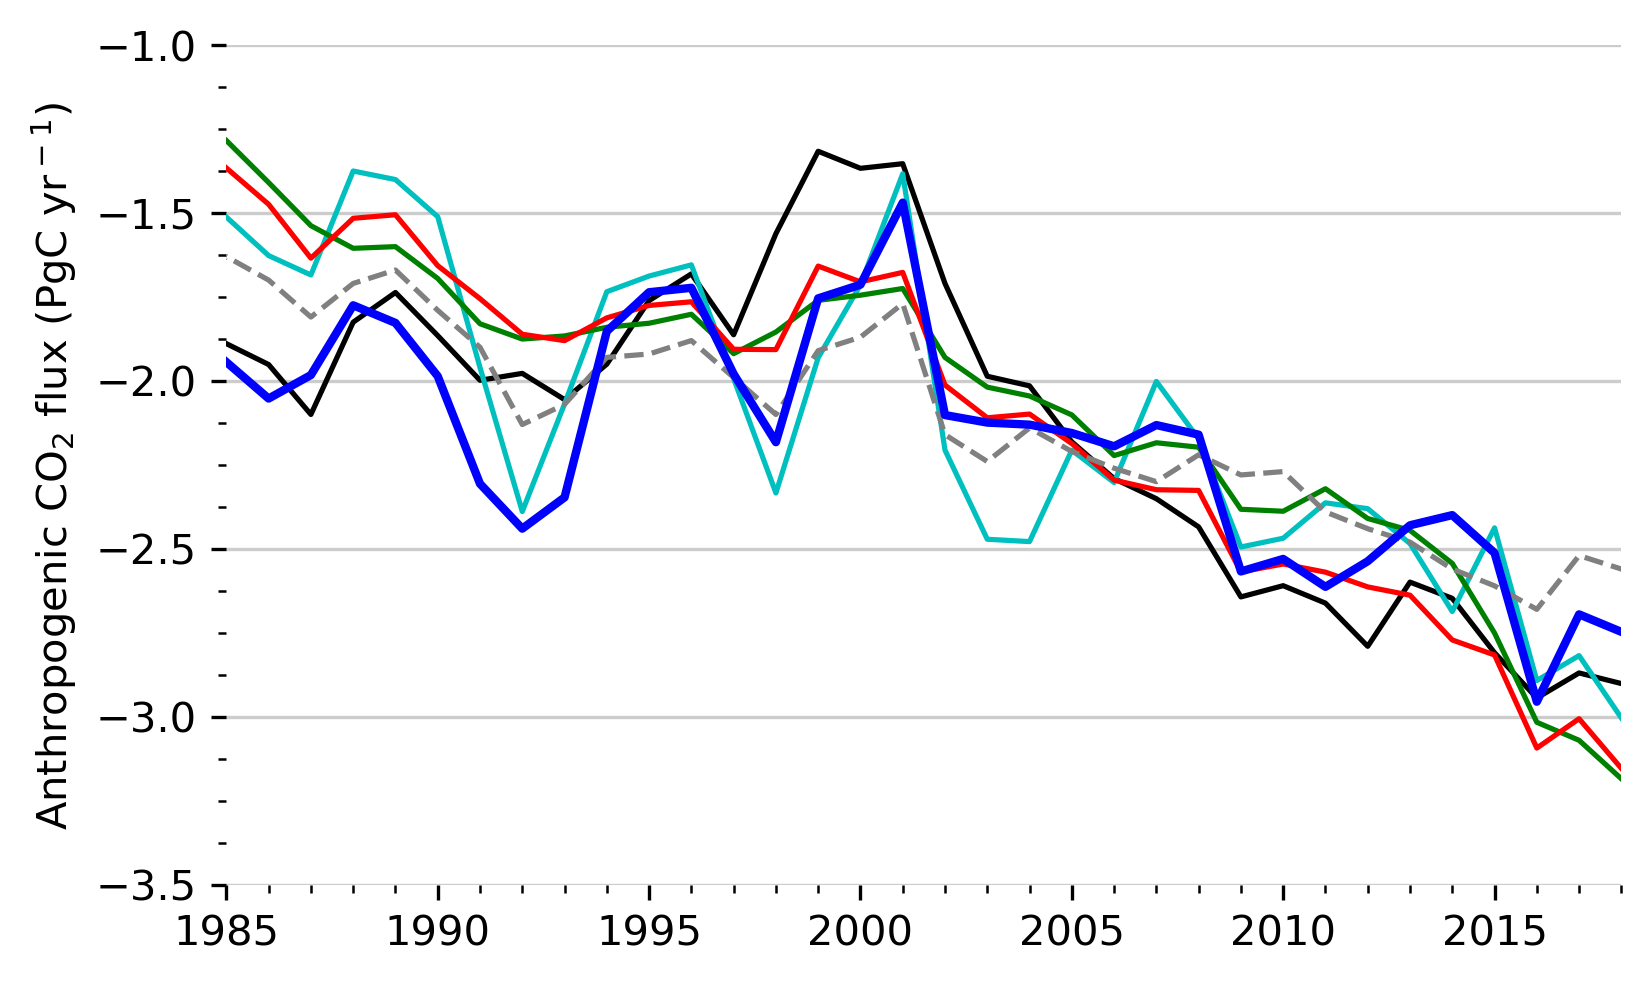

In [32]:
fig = plt.figure(figsize=(6,6/1.618)) 
ax = fig.add_subplot(111)

river_flux = 0.42
# products
ax.plot(flux_den_prods_yr['year'], flux_den_prods_yr.sel(product='MPI-SOMFFN') - river_flux, color='k', linewidth=1.25)
ax.plot(flux_den_prods_yr['year'], flux_den_prods_yr.sel(product='JENA-MLS') - river_flux, color='c', linewidth=1.25)
ax.plot(flux_den_prods_yr['year'], flux_den_prods_yr.sel(product='CMEMS-FFNN2') - river_flux, color='g', linewidth=1.25)
ax.plot(flux_den_prods_yr['year'], flux_den_prods_yr.sel(product='CSIR-ML6') - river_flux, color='r', linewidth=1.25)

# use calcultions from GCB
ax.plot(flux_den_mod['years'], flux_den_mod['Mean models'], color=[0.5,0.5,0.5], linestyle='--', linewidth=1.25)

# ldeo-HPD
ax.plot(flux_den_hpd_yr['year'], flux_den_hpd_yr.mean('model') - river_flux, color='b', linewidth=2)

# Range of axes
ax.set_ylim([-3.5, -1])
ax.set_xlim([1985, 2018])

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)
### Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# major / minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Make axis square
#x0, x1 = ax.get_xlim()
#y0, y1 = ax.get_ylim()
#ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Labels
ax.set_ylabel(f'Anthropogenic CO$_2$ flux (PgC yr$^-$$^1$)')
#ax.set_xlabel(f'Number months with data')

plt.savefig(f'{dir_figs}/flux_time_series_latest.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)

# Correlation map

In [154]:
river_flux=0.49
d = pd.DataFrame(data={'SOMFFN':(flux_den_prods_yr.sel(product='MPI-SOMFFN') - river_flux).values,
                       'MLS': (flux_den_prods_yr.sel(product='JENA-MLS') - river_flux).values,
                       'CMEMS': (flux_den_prods_yr.sel(product='CMEMS-FFNN2') - river_flux).values,
                       'CSIR': (flux_den_prods_yr.sel(product='CSIR-ML6') - river_flux).values,
                       'HPD': (flux_den_hpd_yr.mean('model') - river_flux).values,
                       'GBC': flux_den_mod.where(flux_den_mod['years']>=1985).where(flux_den_mod['years']<2019).dropna()['Mean models'].values,})

In [168]:
river_flux=0.49
d = pd.DataFrame(data={'SOMFFN':signal.detrend((flux_den_prods_yr.sel(product='MPI-SOMFFN') - river_flux).values),
                       'MLS': signal.detrend((flux_den_prods_yr.sel(product='JENA-MLS') - river_flux).values),
                       'CMEMS': signal.detrend((flux_den_prods_yr.sel(product='CMEMS-FFNN2') - river_flux).values),
                       'CSIR': signal.detrend((flux_den_prods_yr.sel(product='CSIR-ML6') - river_flux).values),
                       'HPD': signal.detrend((flux_den_hpd_yr.mean('model') - river_flux).values),
                       'GBC': signal.detrend(flux_den_mod.where(flux_den_mod['years']>=1985).where(flux_den_mod['years']<2019).dropna()['Mean models'].values),})

In [169]:
d.corr()

,SOMFFN,MLS,CMEMS,CSIR,HPD,GBC
SOMFFN,1.000000,0.358692,0.612079,0.870755,0.774462,0.575156
MLS,0.358692,1.000000,0.502268,0.609525,0.748763,0.741290
CMEMS,0.612079,0.502268,1.000000,0.863641,0.663877,0.530923
CSIR,0.870755,0.609525,0.863641,1.000000,0.864963,0.734883
HPD,0.774462,0.748763,0.663877,0.864963,1.000000,0.753542
GBC,0.575156,0.741290,0.530923,0.734883,0.753542,1.000000


In [156]:
from scipy import signal
#randgen = np.random.RandomState(9)
#npoints = 1000
#noise = randgen.randn(npoints)
#x = 3 + 2*np.linspace(0, 1, npoints) + noise
#tmp = signal.detrend(d)

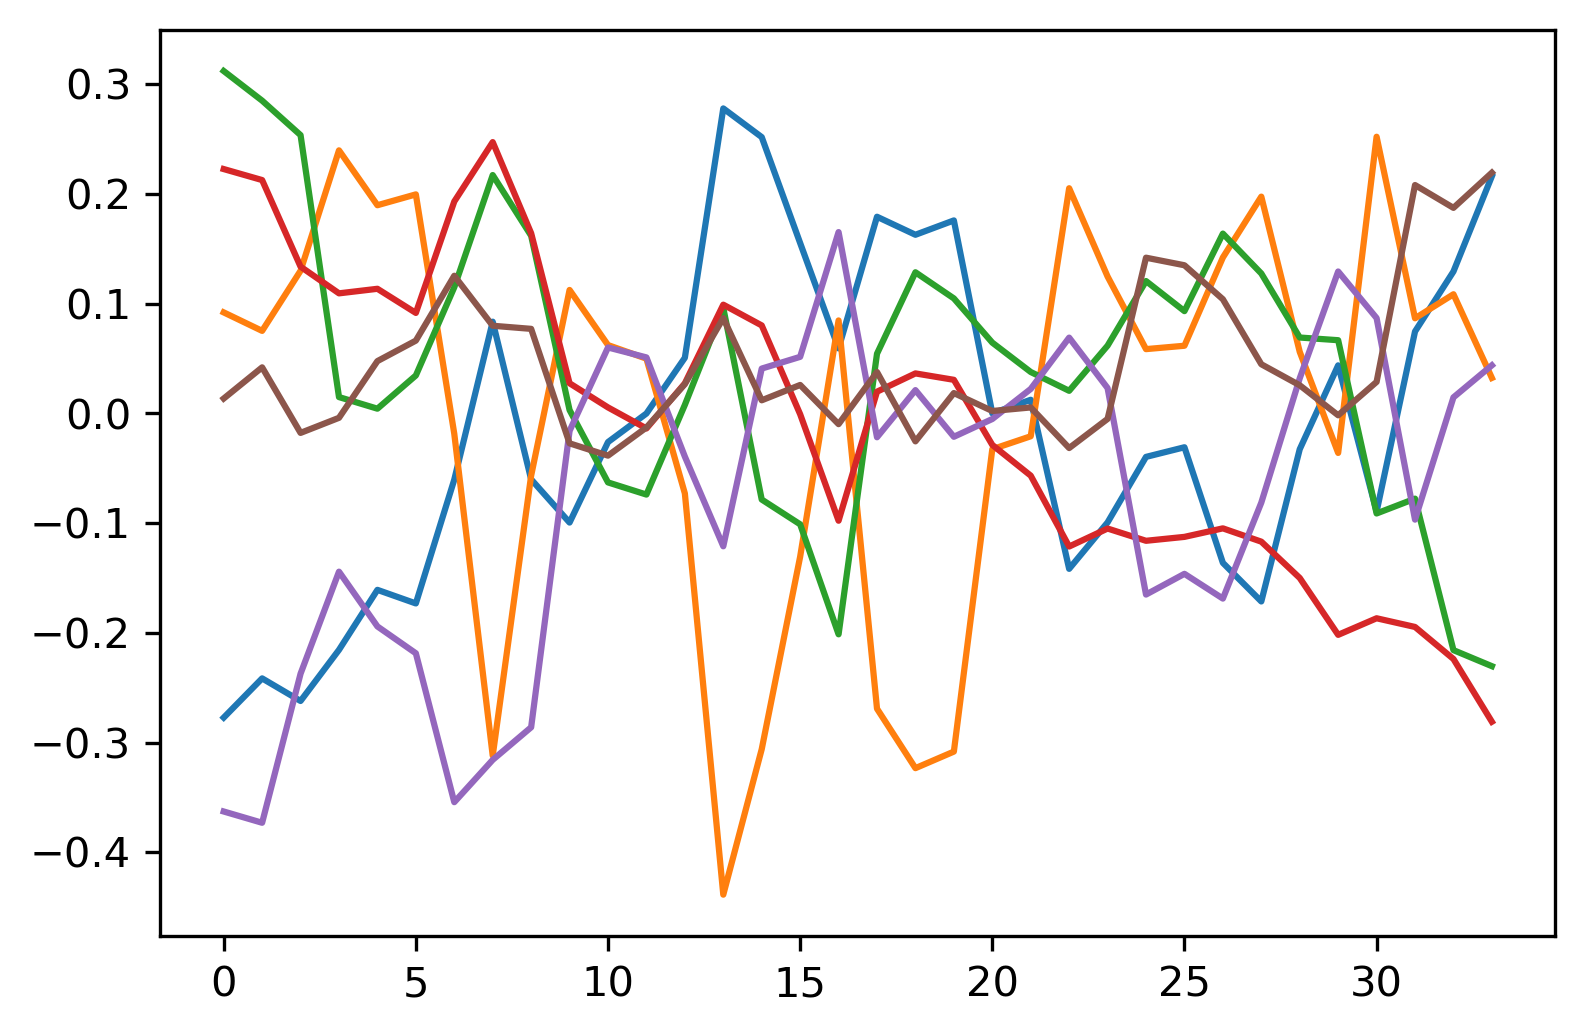

In [164]:
for val in range(0,6):
    plt.plot(tmp[:,val])

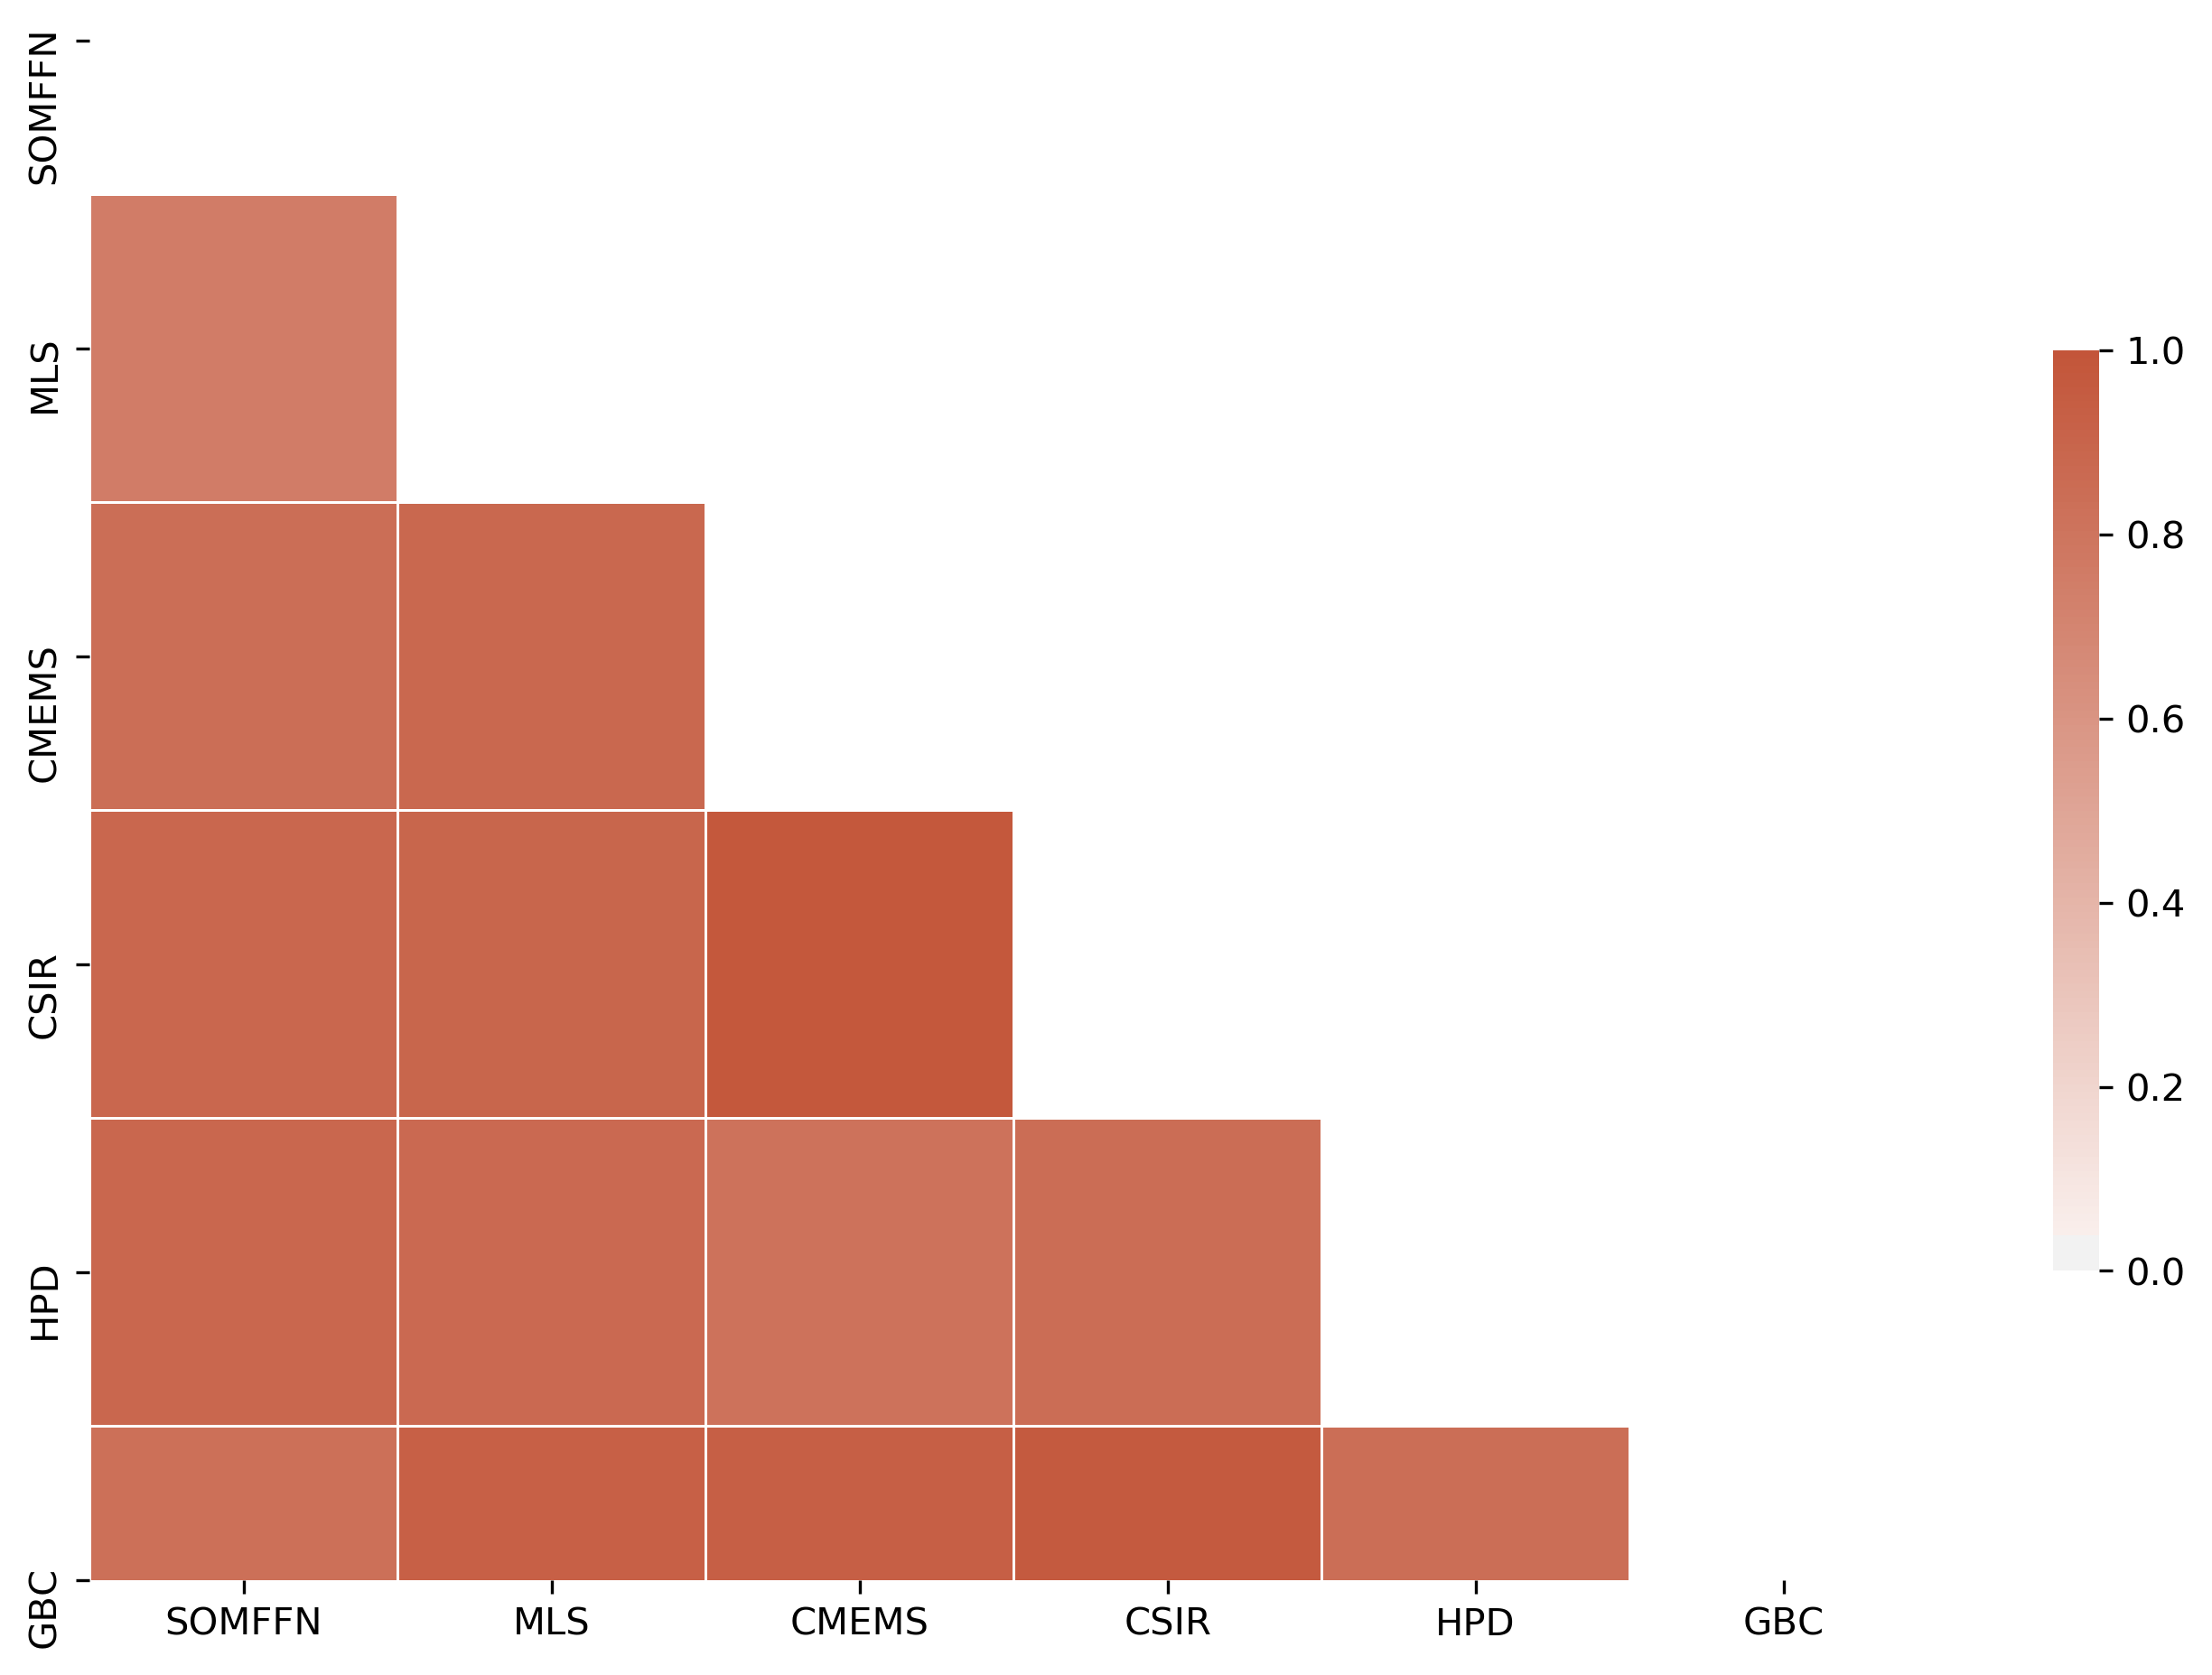

In [140]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Plot each model

Text(0, 0.5, 'Anthropogenic CO$_2$ flux (PgC yr$^-$$^1$)')

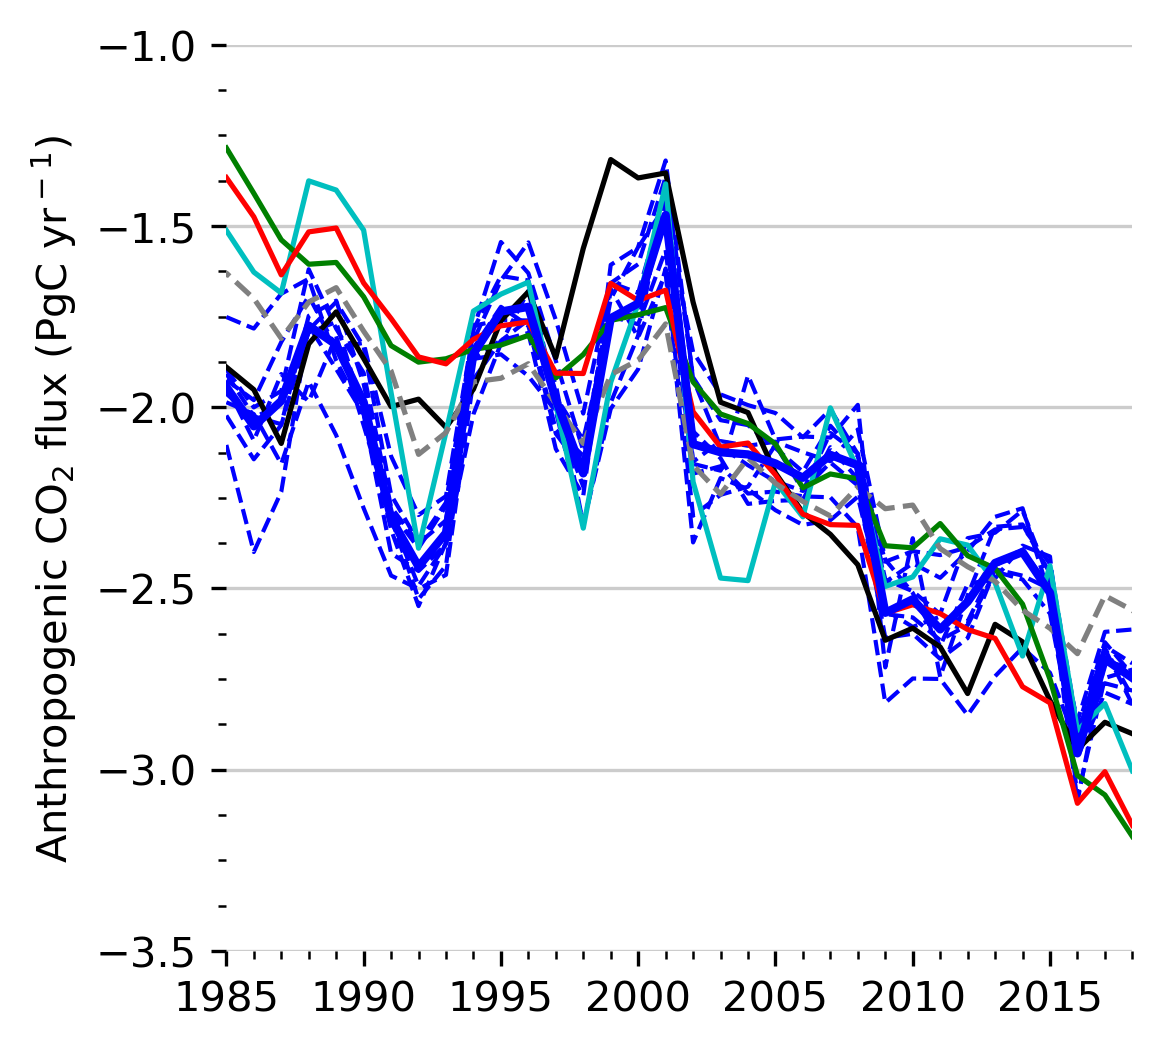

In [41]:
fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot(111)

river_flux = 0.42

# ldeo-HPD
for model in list(flux_den_hpd_yr.model.values):
    ax.plot(flux_den_hpd_yr['year'], flux_den_hpd_yr.sel(model=model) - river_flux, color='b', linewidth=1, linestyle='--')
    
    
# products
ax.plot(flux_den_prods_yr['year'], flux_den_prods_yr.sel(product='MPI-SOMFFN') - river_flux, color='k', linewidth=1.25)
ax.plot(flux_den_prods_yr['year'], flux_den_prods_yr.sel(product='JENA-MLS') - river_flux, color='c', linewidth=1.25)
ax.plot(flux_den_prods_yr['year'], flux_den_prods_yr.sel(product='CMEMS-FFNN2') - river_flux, color='g', linewidth=1.25)
ax.plot(flux_den_prods_yr['year'], flux_den_prods_yr.sel(product='CSIR-ML6') - river_flux, color='r', linewidth=1.25)

# use calcultions from GCB
ax.plot(flux_den_mod['years'], flux_den_mod['Mean models'], color=[0.5,0.5,0.5], linestyle='--', linewidth=1.25)


 
ax.plot(flux_den_hpd_yr['year'], flux_den_hpd_yr.mean('model') - river_flux, color='b', linewidth=2)

# Range of axes
ax.set_ylim([-3.5, -1])
ax.set_xlim([1985, 2018])

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)
### Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# major / minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Make axis square
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Labels
ax.set_ylabel(f'Anthropogenic CO$_2$ flux (PgC yr$^-$$^1$)')
#ax.set_xlabel(f'Number months with data')

#plt.savefig(f'{dir_figs}/flux_time_series_latest.pdf', 
#                transparent = True, 
#                bbox_inches = 'tight', 
#                pad_inches = 0)

# decdal mean flux

In [5]:
ds = xr.open_dataset('/local/data/artemis/workspace/gloege/ldeo-hpd/LDEO-HPD_fgco2_v20210426_1x1_198201-201812.nc')

In [7]:
ds_spco2  = xr.open_dataset('/local/data/artemis/workspace/gloege/ldeo-hpd/LDEO-HPD_spco2_v20210426_1x1_198201-201812.nc')

In [9]:
mask = (ds_spco2['spco2'].sel(model='cesm').mean('time')>0)*1

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [14]:
ds_fgco2 = ds['fgco2_avg'].mean('model')

In [33]:
total_area = ds['area'].sum()

# calculate regional averages (mol/m2/s)
grams_in_mol = 12.01            # g/mol
sec_to_year = 86400 * 365       # sec/year
gram_to_petagram = 1 / (10**15) # Pg/g

# conversion to mol/s to Pg/yr
conversion = grams_in_mol * gram_to_petagram * sec_to_year

((((ds_fgco2*conversion)*ds['area']).sum(['lat','lon']))).sel(time=slice('2010-01','2018-12')).mean('time')

<xarray.DataArray ()>
array(-2.22919213)

# old code

In [ ]:
ds_mod = xr.open_dataset('/local/data/artemis/simulations/GCB/2020models/gcb_load_A_2020.nc', decode_times=False)

models = [ 'cesm_fgco2_1x1_A', 
           'csiro_fgco2_1x1_A',
           'fesom_fgco2_1x1_A',
           'mpi_fgco2_1x1_A', 
           'cnrm_fgco2_1x1_A',
           'ipsl_fgco2_1x1_A',
           'planktom_fgco2_1x1_A',
           'noresm_fgco2_1x1_A',
           'princeton_fgco2_1x1_A',]

# initialize
ds_mod['model_avg'] = ds_mod['cesm_fgco2_1x1_A']*0

# add all the models
for mod in models:
    ds_mod['model_avg'] +=  ds_mod[mod]
    
# average models molC/m^2/s
ds_mod['model_avg'] =  ds_mod['model_avg']/len(models)

ds_mod = ds_mod.rename({'X':'lon', 'Y':'lat','T':'time'})
ds_mod['time'] = make_dates(start='1958-01', end='2019-12')

In [ ]:
#flux_den_mod = ((ds_mod[models]*(12.01/10**15)*(365*86400))*ds_prod['area']).sum(['lat','lon'])
flux_den_mod['model_avg'] = flux_den_mod['cesm_fgco2_1x1_A']*0

for mod in models:
    flux_den_mod['model_avg'] +=  flux_den_mod[mod]
    
# average models molC/m^2/s
flux_den_mod['model_avg'] =  flux_den_mod['model_avg']/len(models)
flux_den_mod_yr = flux_den_mod.groupby('time.year').mean('time')


flux_den_mod_yr = flux_den_mod.groupby('time.year').mean('time')
flux_den_mod_yr['model_avg'] = flux_den_mod_yr['cesm_fgco2_1x1_A']*0

for mod in models:
    flux_den_mod_yr['model_avg'] +=  flux_den_mod_yr[mod]
    
# average models molC/m^2/s
flux_den_mod_yr['model_avg'] =  flux_den_mod_yr['model_avg']/len(models)

## OLD

In [ ]:
ds_gbc = xr.Dataarray(
    {
    'flux':(['year'], flux_den_mod['Mean models'])
    },
    coords={ 'year': (['year'],  flux_den_mod['years']),
    })

In [ ]:
#ds_hpd = xr.open_dataset('/home/gloege/projects/ldeo_hpd/data/fgco2/fgco2_mon_1x1_198201-201612.nc')
#dir_reccap='/local/data/artemis/workspace/gloege/RECCAP2'
#ds_hpd = xr.open_dataset(f'{dir_reccap}/LDEO-HPD-average_v2021a_1x1_198201-201812.nc')

#dir_reccap='/local/data/artemis/workspace/gloege/RECCAP2'
#ds_hpd = xr.open_dataset(f'{dir_reccap}/LDEO-HPD-average_v2021a_1x1_198201-201812.nc')
#flux_den_hpd_yr = ds_hpd['fgco2_glob'].groupby('time.year').mean('time')

# the newest xco2 version
dir_reccap='/local/data/artemis/workspace/gloege/RECCAP2'
ds_hpd = xr.open_dataset(f'{dir_reccap}/LDEO-HPD-average_v20210413_1x1_198201-201812.nc')
flux_den_hpd_yr = ds_hpd['fgco2_glob'].groupby('time.year').mean('time')

#dir_reccap='/local/data/artemis/workspace/gloege/RECCAP2'
#ds_xco2 = xr.open_dataset(f'{dir_reccap}/LDEO-HPD-plus_xco2.nc')
#flux_den_xco2_yr = ds_xco2['fgco2'].groupby('time.year').mean('time')

#ds_hpd2=xr.open_dataset('/home/gloege/projects/ldeo_hpd/data/fgco2/old_fluxes/fgco2_mon_1x1_198201-201612.nc')

In [ ]:
sec_to_year = 86400 * 365 
flux_den_xco2 = ( (ds_xco2['fgco2']*sec_to_year).mean('wind')*(12.01/10**15)*ds_xco2['area']).sum(['lat','lon'])
flux_den_xco2_yr = flux_den_xco2.groupby('time.year').mean('time')

#ds_hpd['fgco2_AVG'] = ds_hpd['fgco2'].sel(wind=['CCMP2','ERA5','JRA55']).mean('wind')
#ds_hpd['fgco2_STD'] = ds_hpd['fgco2'].sel(wind=['CCMP2','ERA5','JRA55']).mean('wind')

#flux_den_hpd = (ds_hpd['fgco2_AVG']*(12.01/10**15)*ds_area['area']).sum(['lat','lon'])
#flux_den_hpd = (ds_hpd['fgco2']*(12.01/10**15)*ds_prod['area']).sum(['lat','lon'])
#flux_den_hpd_yr = flux_den_hpd.groupby('time.year').mean('time')

#flux_den_hpd_yr = ds_hpd['fgco2_glob'].groupby('time.year').mean('time')

In [ ]:
#flux_den_mod = ( (ds_mod['model_avg']*(12.01/10**15)*(365*86400))*ds_prod['area']).sum(['lat','lon'])
#flux_den_mod_yr = flux_den_mod.groupby('time.year').mean('time')

# old bars

In [ ]:
fig = plt.figure(figsize=(6,6/1.618)) 
ax = fig.add_subplot(111)

bar_width = 1/8
edgecolor = 'w'
# -------------------------------------
# Plot data
# table ts.1 https://www.ipcc.ch/site/assets/uploads/2018/05/ar4_wg1_full_report-1.pdf
# -------------------------------------
label = ['90_99', '00_09']
means = [-2.2, -2.6 + 0.38]
std = [0.4, 0.3]
positions = np.arange(0,len(means))
ax.bar(positions, means, color=[0.8,0.8,0.8], edgecolor=edgecolor, yerr=std, width=bar_width) #hatch='/')
#ax.bar(positions, means, color=[0.8,0.8,0.8], edgecolor=edgecolor, yerr=std, width=bar_width, hatch='/')
#ax.rcParams['hatch.color'] = 'k'

# -------------------------------------
# Jacobson river flux
# -------------------------------------
mult=1
means = [da_gbc.sel(year=slice(1990,1999)).mean(), 
         da_gbc.sel(year=slice(1994,2007)).mean()]
ax.bar(positions+mult*bar_width, means, color=[0.5,0.5,0.5], edgecolor=edgecolor, width=bar_width, yerr=[0.47,0.49])

mult = 2
colors = ['b', 'k', 'c', 'g', 'r']
for data in [flux_den_hpd_yr,  
             flux_den_prods_yr.sel(product='MPI-SOMFFN'), 
             flux_den_prods_yr.sel(product='JENA-MLS'),
             flux_den_prods_yr.sel(product='CMEMS-FFNN2'),
             flux_den_prods_yr.sel(product='CSIR-ML6')]:
    mn_1990_1999 = data.sel(year=slice(1990,1999)).mean()
    mn_1994_2007 = data.sel(year=slice(1994,2007)).mean()
    means = [mn_1990_1999-0.49, mn_1994_2007-0.49]
    
    # add bar plot
    ax.bar(positions+mult*bar_width, means, color=colors[mult-2], 
           edgecolor=edgecolor, width=bar_width, yerr=[0.52,0.52], ecolor=[0.5,0.5,0.5]) #yerr=[[-0.4],[-0.1]],
    
    mult = mult+1
    

# -------------------------------------
# Contempory flux 
# -------------------------------------
mult=2
#colors = ['b',  [0.5,0.5,0.5], 'k', 'c', 'g', 'r']
colors = ['b', 'k', 'c', 'g', 'r']
for data in [flux_den_hpd_yr,  
             flux_den_prods_yr.sel(product='MPI-SOMFFN'), 
             flux_den_prods_yr.sel(product='JENA-MLS'),
             flux_den_prods_yr.sel(product='CMEMS-FFNN2'),
            flux_den_prods_yr.sel(product='CSIR-ML6')]:
    mn_1990_1999 = data.sel(year=slice(1990,1999)).mean()
    mn_1994_2007 = data.sel(year=slice(1994,2007)).mean()
    means = [mn_1990_1999, mn_1994_2007]
    
    # add bar plot
    ax.bar(positions+mult*bar_width, means, color=colors[mult-2], 
           edgecolor=edgecolor, width=bar_width) #yerr=[[-0.4],[-0.1]],
    mult = mult+1

    
positions= 2
mult=3
colors = ['b', 'k', 'c', 'g', 'r']
for data in out_2009:

    #means = [mn_1990_1999-0.49, mn_1994_2007-0.49]
    
    # add bar plot
    ax.bar(positions+mult*bar_width, data, color=colors[mult-3], 
           edgecolor=edgecolor, width=bar_width, yerr=[0.52], ecolor=[0.5,0.5,0.5]) #yerr=[[-0.4],[-0.1]],
    
    mult = mult+1

# Range ov axes
#ax.set_ylim([-3, 0])
#ax.set_xlim([-0.5, 1])

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

## Remove x tick marks
#plt.setp(ax.get_xticklabels(), rotation=0)
### Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

### major / minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

### Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
#ax.xaxis.set_ticks_position('bottom')

### Make axis square
#x0, x1 = ax.get_xlim()
#y0, y1 = ax.get_ylim()
#ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

## Labels
ax.set_ylabel(f'Anthropogenic flux (PgC $yr^{-1}$)')
#ax.set_xlabel(f'Number months with data')

#plt.savefig(f'{dir_figs}/flux_bar_latest.pdf', 
#                transparent = True, 
#                bbox_inches = 'tight', 
#                pad_inches = 0)